Data required :

From trained model (mcRBM output)
*   uniqueStates.npz
*   latentStates.npz
*   obsKeys.npz

From test post trial (mcRBM output)
*   uniqueStatespt.npz
*   latentStatespt.npz
*   obsKeyspt.npz

***!!! Make sure the test data from post trial has been inputed in the mcRBM in chronological order!!!***

---

## Load data

In [33]:
!pip install seaborn

In [34]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import h5py as h5
import seaborn as sns
from scipy.stats import mode
from matplotlib.colors import LinearSegmentedColormap

In [35]:
fs = 1000
window_length = fs*2
epoch_length = int(window_length/fs)

# Load data from trained model
latent_states = np.load('latentStates.npz')
unique_states = np.load('uniqueStates.npz')
obs_keys = np.load('obsKeys.npz')

# Load data from test on post trial 5 (pt5)
latent_states_pt = np.load('latentStatespt.npz')
unique_states_pt = np.load('uniqueStatespt.npz')
obs_keys_pt = np.load('obsKeyspt.npz')

inferredStates = latent_states['inferredStates']
uniqueStates = unique_states['uniqueStates']
obsKeys = obs_keys['obsKeys']
uniqueStatesStr = [''.join(map(str, row[13:].astype(int))) for row in uniqueStates]  # Binary code for a given latent state (primary key to compare latent states from training and test) = neuron activations

inferredStates_pt = latent_states_pt['inferredStates']
uniqueStates_pt = unique_states_pt['uniqueStates']
obsKeys_pt = obs_keys_pt['obsKeys']
uniqueStatesStr_pt = [''.join(map(str, row[13:].astype(int))) for row in uniqueStates_pt]

states = inferredStates_pt[:,1]

'''# Mark as NaN all elements that are either artefact or transitional states(TS) - so that these don't appear in the plots
indices = np.where((states != 1) & (states != 3) & (states != 5))[0]  # Get indices of all epochs that are not in the inferred states epochs (score = 0 and 4)
states[indices] = 0'''

"# Mark as NaN all elements that are either artefact or transitional states(TS) - so that these don't appear in the plots\nindices = np.where((states != 1) & (states != 3) & (states != 5))[0]  # Get indices of all epochs that are not in the inferred states epochs (score = 0 and 4)\nstates[indices] = 0"

## Prepare plot data

In [36]:
# Defining x axis in secs

times = np.arange(len(inferredStates_pt))*2

In [37]:
# Getting the inferred latent state (1, 3 or 5) and the probability based on training results[]

majority_inferred_states = []
wake_prob = []
nrem_prob = []
rem_prob = []

for i in uniqueStates[:, 0]:
    idx = np.where(obsKeys[:, 1] == i )[0]                                                            # majority_inferred_states is list of inferred states of test dataset base on proportions from the training. The binary code (from neuron activation) is used to find the corresponding latent state in training results.
    bin = uniqueStatesStr[i]                                                                          # probabilities is the proportion of the majority state in the corresponding latent state from training
    i_pt =-1
    for i, el in enumerate(uniqueStatesStr_pt):
      if bin == el:
        i_pt = i
    if i_pt != -1 :
      idx_pt = np.where(obsKeys_pt[:, 1] == i_pt)[0]
      latent_frames = obsKeys[idx, :]
      latent_frames_pt = obsKeys_pt[idx_pt, :]
      awake_pct = round((len(np.where((latent_frames[:,3]==1))[0])/float(len(latent_frames))),3)
      nrem_pct = round((len(np.where((latent_frames[:,3]==3))[0])/float(len(latent_frames))),3)
      rem_pct = round((len(np.where((latent_frames[:,3]==5))[0])/float(len(latent_frames))),3)

      wake_prob.append(awake_pct)
      nrem_prob.append(nrem_pct)
      rem_prob.append(rem_pct)

      if awake_pct >= nrem_pct and awake_pct >= rem_pct:
        majority_inferred_states.append(1)
      elif nrem_pct >= rem_pct and nrem_pct > awake_pct:
        majority_inferred_states.append(3)
      elif rem_pct > nrem_pct and rem_pct > awake_pct:
        majority_inferred_states.append(5)

## Conventional hypnodensity graph

In [38]:
data = []
for elt in inferredStates_pt[:,0]:
  data.append([wake_prob[int(elt)-1], rem_prob[int(elt)-1], nrem_prob[int(elt)-1]])               # get [wake,rem,nrem] probabilities for each epoch
data = np.array(data)

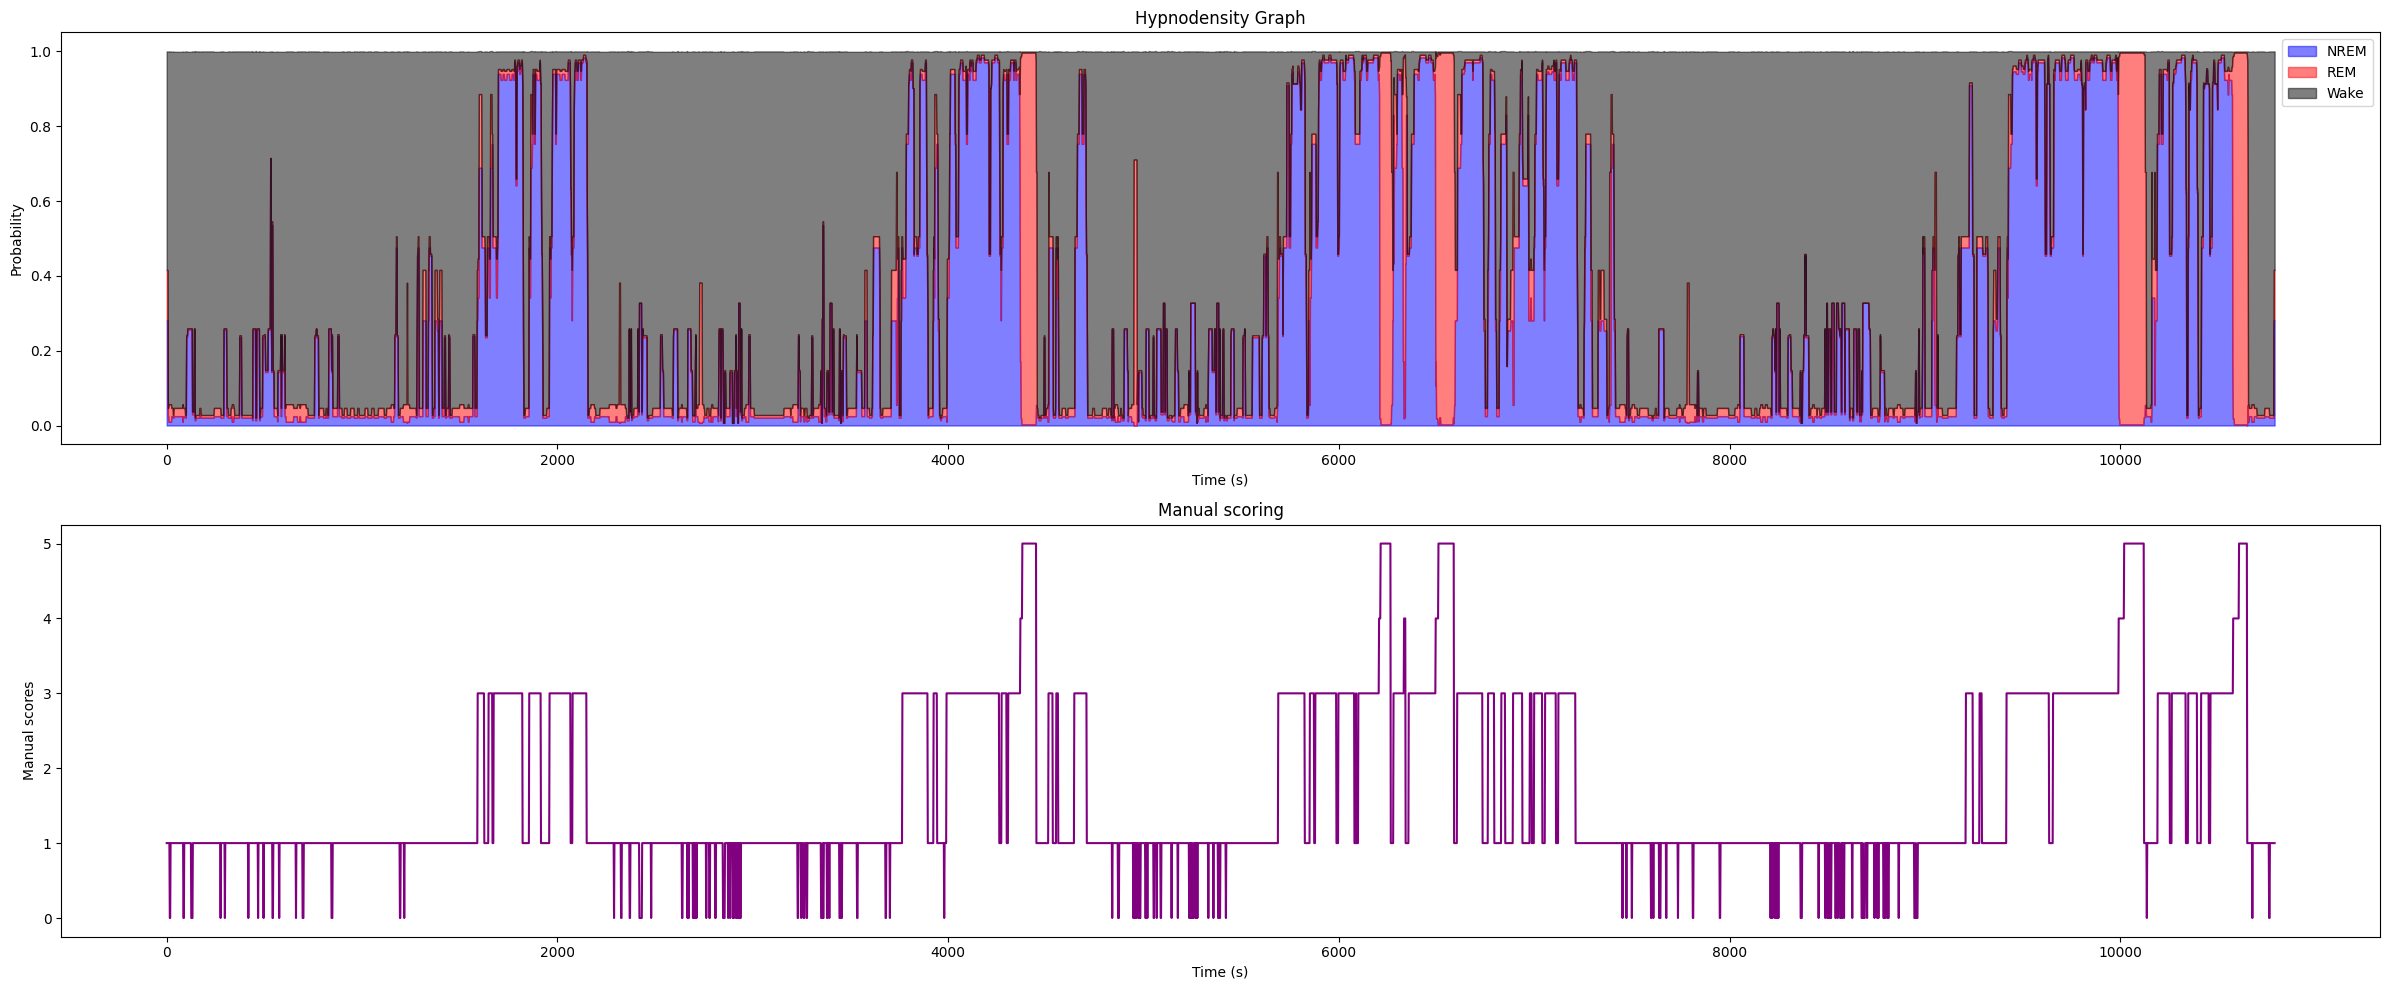

In [39]:
#@title Entire post trial

fig, axs = plt.subplots(2, 1, figsize=(24, 10))

axs[0].fill_between(times, 0, data[:, 2], color='blue', alpha=0.5, label='NREM')
axs[0].fill_between(times, data[:, 2], data[:, 2] + data[:, 1], color='red', alpha=0.5, label='REM')
axs[0].fill_between(times, data[:, 2] + data[:, 1], data[:, 2] + data[:, 1] + data[:, 0], color='black', alpha=0.5, label='Wake')

axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Probability')
axs[0].set_title('Hypnodensity Graph')
axs[0].legend(loc='upper right')

axs[1].plot(times, states, color='purple')    #manual scoring
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Manual scores')
axs[1].set_title('Manual scoring')

# Display the plot
plt.tight_layout()
plt.savefig('FullHypnodensityGraph.svg', format = 'svg')
plt.show()

### Zooms

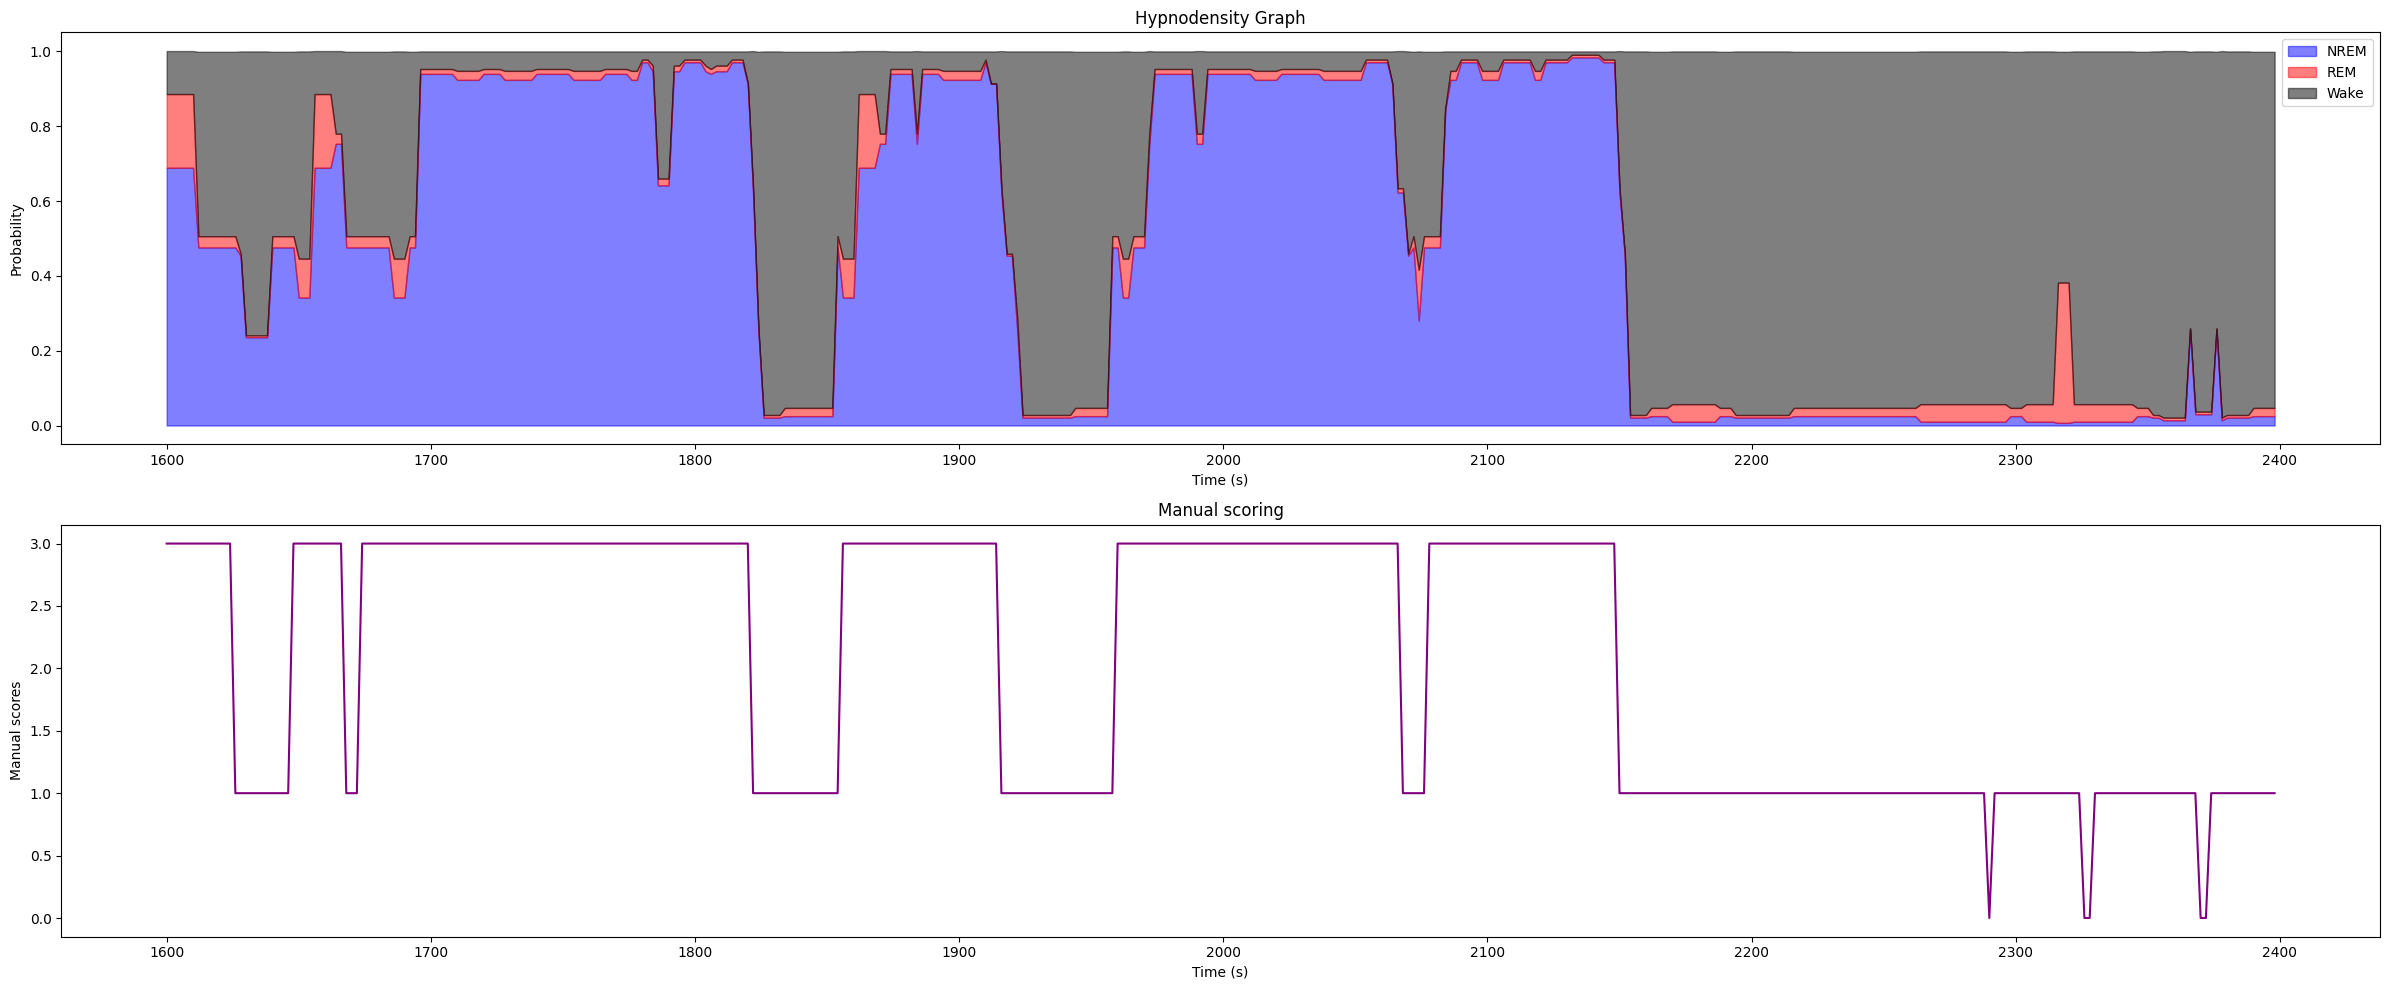

In [40]:
#@title 1600-2400 zoom

times = np.arange(800,1200)     # interval /2
fig, axs = plt.subplots(2, 1, figsize=(24, 10))

axs[0].fill_between(times*2, 0, data[times, 2], color='blue', alpha=0.5, label='NREM')
axs[0].fill_between(times*2, data[times, 2], data[times, 2] + data[times, 1], color='red', alpha=0.5, label='REM')
axs[0].fill_between(times*2, data[times, 2] + data[times, 1], data[times, 2] + data[times, 1] + data[times, 0], color='black', alpha=0.5, label='Wake')

axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Probability')
axs[0].set_title('Hypnodensity Graph')
axs[0].legend(loc='upper right')

axs[1].plot(times*2, states[times], color='purple')    #manual scoring
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Manual scores')
axs[1].set_title('Manual scoring')

# Display the plot
plt.tight_layout()
plt.savefig('HypnodensityGraphZoom1.svg', format = 'svg')
plt.show()

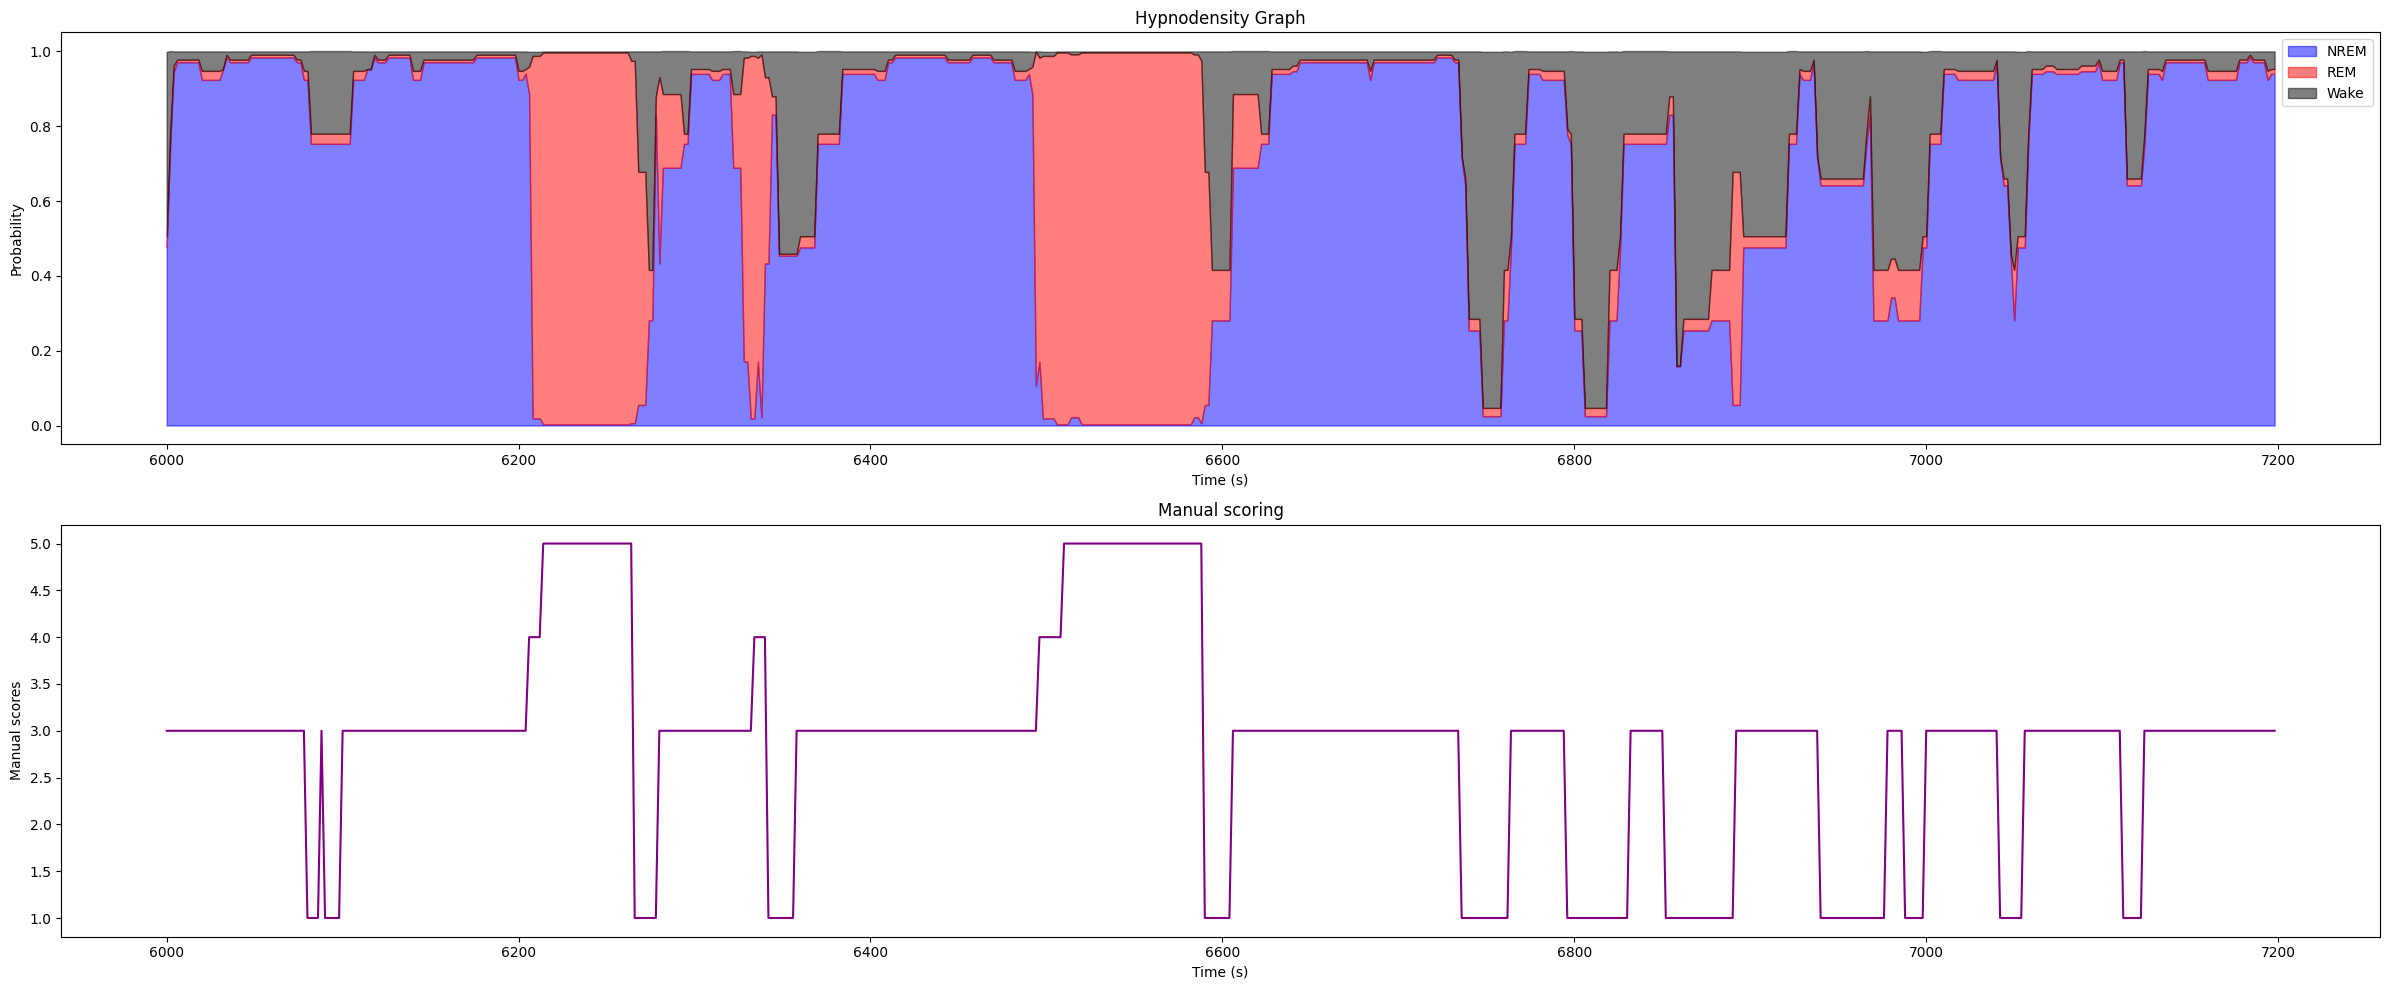

In [41]:
#@title 6000-7200 zoom

times = np.arange(3000,3600)  # interval /2
fig, axs = plt.subplots(2, 1, figsize=(24, 10))

axs[0].fill_between(times*2, 0, data[times, 2], color='blue', alpha=0.5, label='NREM')
axs[0].fill_between(times*2, data[times, 2], data[times, 2] + data[times, 1], color='red', alpha=0.5, label='REM')
axs[0].fill_between(times*2, data[times, 2] + data[times, 1], data[times, 2] + data[times, 1] + data[times, 0], color='black', alpha=0.5, label='Wake')

axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Probability')
axs[0].set_title('Hypnodensity Graph')
axs[0].legend(loc='upper right')

axs[1].plot(times*2, states[times], color='purple')    #manual scoring
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Manual scores')
axs[1].set_title('Manual scoring')

# Display the plot
plt.tight_layout()
plt.savefig('HypnodensityGraphZoom2.svg', format = 'svg')
plt.show()

## Other hypnodensity graph    (Burns the eyes)


In [ ]:
indices = np.where(np.logical_or(states == 0, states == 4))[0]
inferred_hypno = np.zeros(len(states))
c=0
for i in range(len(inferred_hypno)):
  if i not in indices:
    inferred_hypno[int(i)] = majority_inferred_states[int(inferredStates_pt[int(c),0]-1)]
    c+=1
    print (i)
  print (i)

Streaming output truncated to the last 5000 lines.
2836
2837
2837
2838
2838
2839
2839
2840
2840
2841
2841
2842
2842
2843
2843
2844
2844
2845
2845
2846
2846
2847
2847
2848
2848
2849
2849
2850
2850
2851
2851
2852
2852
2853
2853
2854
2854
2855
2855
2856
2856
2857
2857
2858
2858
2859
2859
2860
2860
2861
2861
2862
2862
2863
2863
2864
2864
2865
2865
2866
2866
2867
2867
2868
2868
2869
2869
2870
2870
2871
2871
2872
2872
2873
2873
2874
2874
2875
2875
2876
2876
2877
2877
2878
2878
2879
2879
2880
2880
2881
2881
2882
2882
2883
2883
2884
2884
2885
2885
2886
2886
2887
2887
2888
2888
2889
2889
2890
2890
2891
2891
2892
2892
2893
2893
2894
2894
2895
2895
2896
2896
2897
2897
2898
2898
2899
2899
2900
2900
2901
2901
2902
2902
2903
2903
2904
2904
2905
2905
2906
2906
2907
2907
2908
2908
2909
2909
2910
2910
2911
2911
2912
2912
2913
2913
2914
2914
2915
2915
2916
2916
2917
2917
2918
2918
2919
2919
2920
2920
2921
2921
2922
2922
2923
2923
2924
2924
2925
2925
2926
2926
2927
2927
2928
2928
2929
2929
2930
2930
2931

In [ ]:
heatmap = max_array = np.maximum(np.maximum(data[:,0], data[:,1]), data[:,2])

In [ ]:
heatmap[indices] = 0

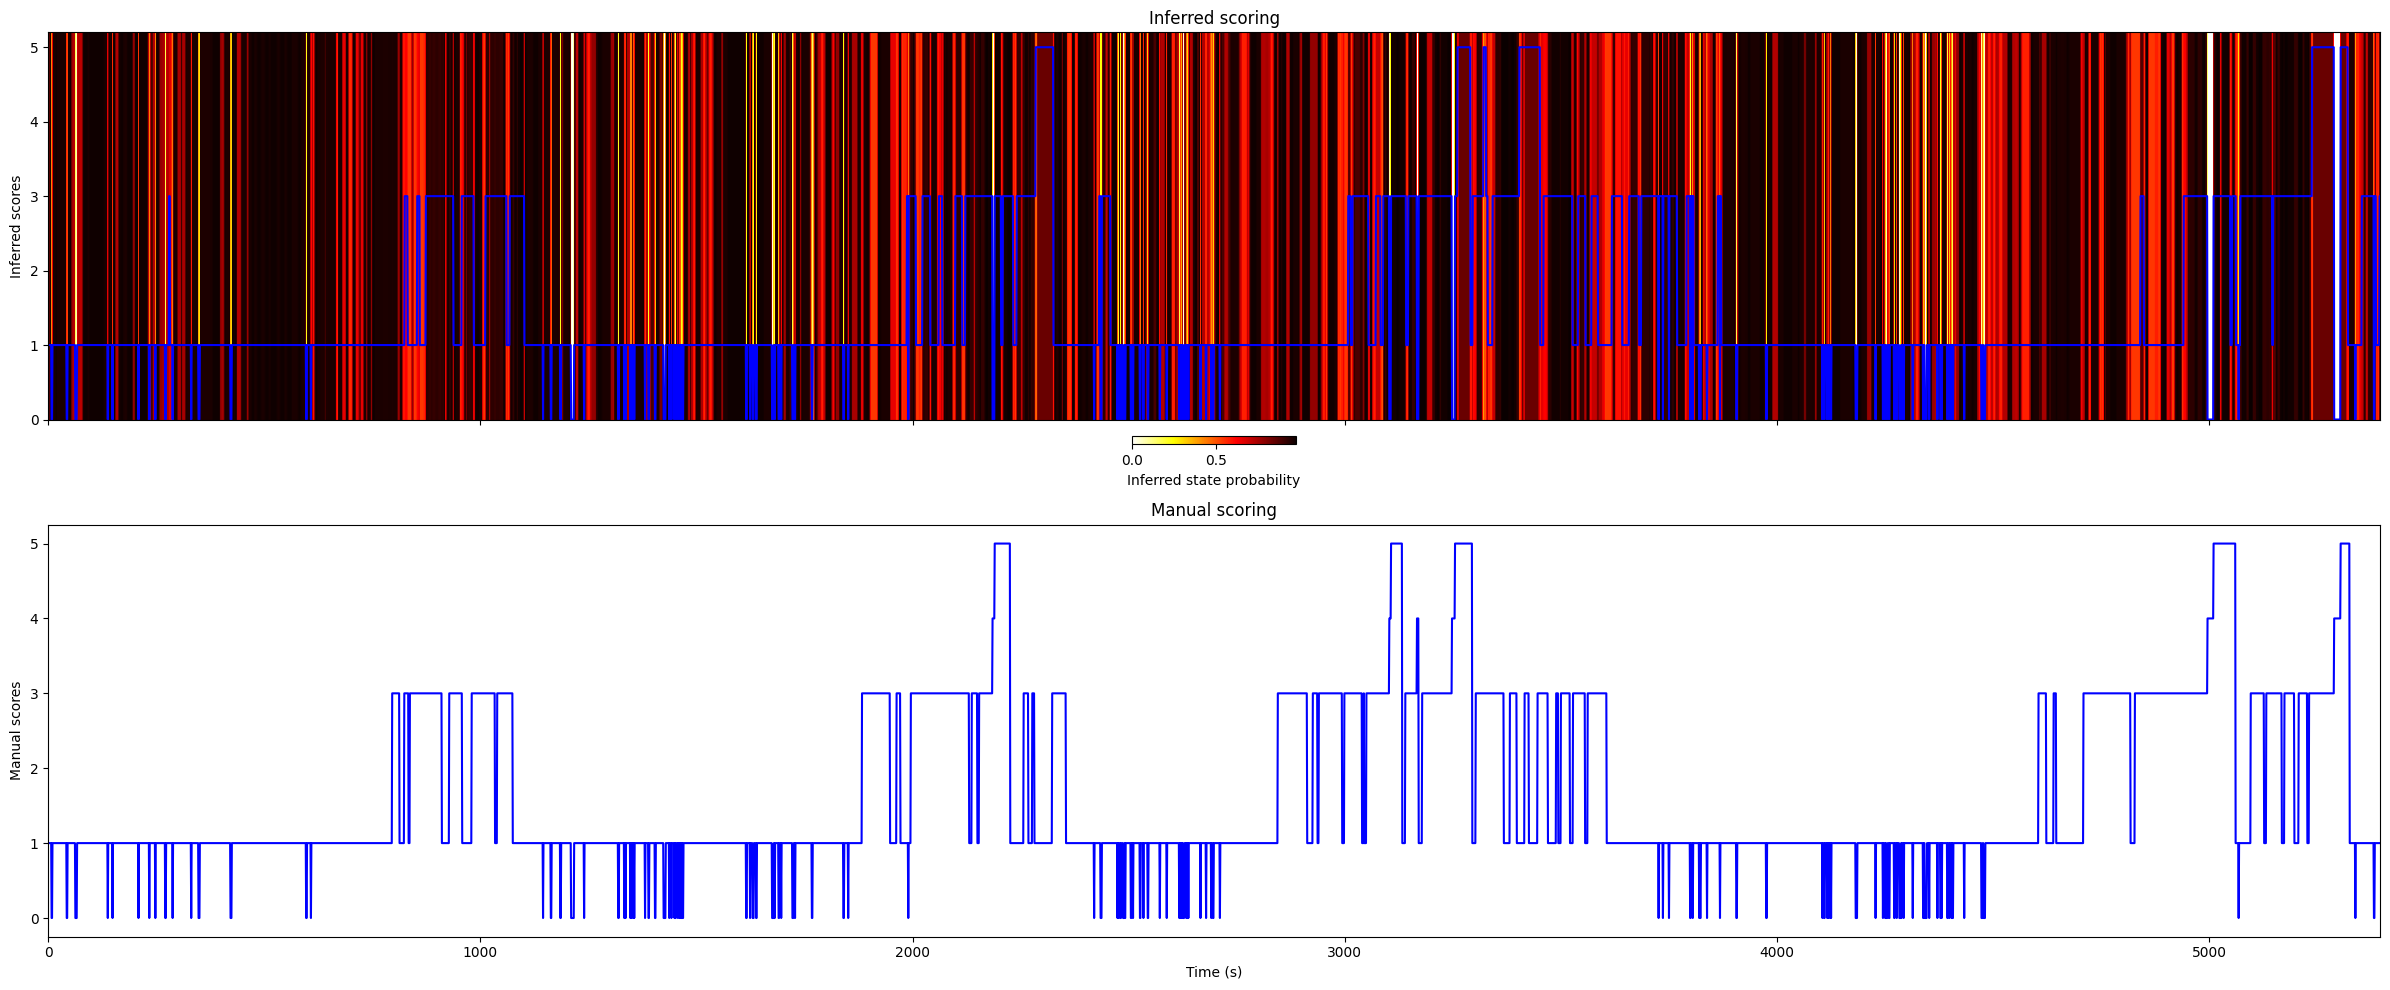

In [ ]:
times = np.arange(0,len(states))
fig, axs = plt.subplots(2, 1, figsize=(24, 10), sharex = True)

axs[0].plot(times, inferred_hypno[times], color='blue')    #manual scoring
axs[0].set_ylabel('Inferred scores')
axs[0].set_title('Inferred scoring')


extent = [times[0], times[-1], 0, 5.2]
im = axs[0].imshow(heatmap[np.newaxis, :], aspect='auto', cmap='hot', extent=extent)
im.set_cmap('hot_r')

axs[1].plot(times, states[times], color='blue')    #manual scoring
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Manual scores')
axs[1].set_title('Manual scoring')

cbar = fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.02, pad=0.04)
cbar.set_label('Inferred state probability')

# Display the plot
plt.tight_layout()
plt.show()

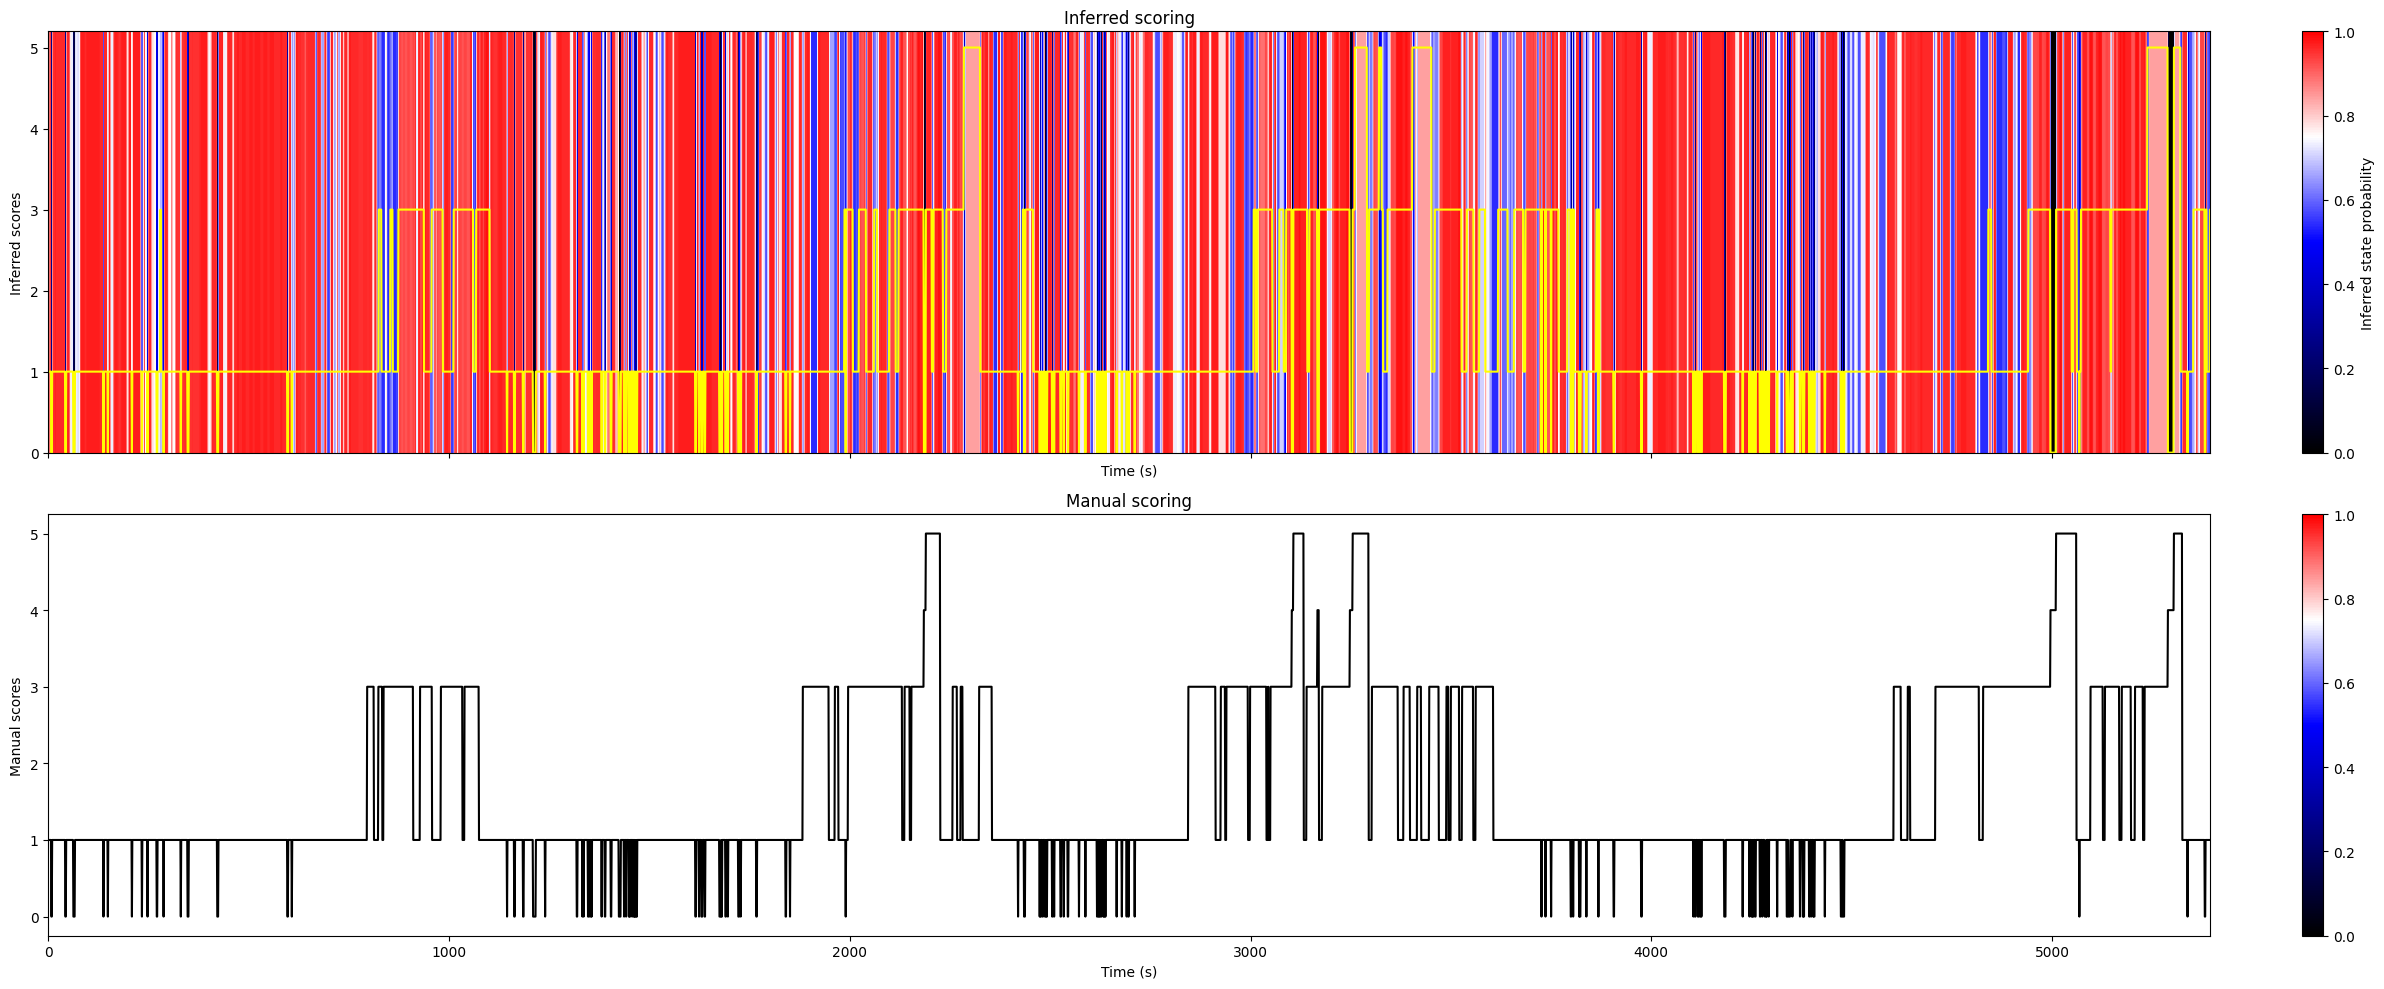

In [ ]:
# Plotting setup
fig, axs = plt.subplots(2, 1, figsize=(24, 10), sharex= True)

# Plot inferred scoring and heatmap
axs[0].plot(times, inferred_hypno, color='yellow')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Inferred scores')
axs[0].set_title('Inferred scoring')

extent = [times[0], times[-1], 0, 5.2]

# Define custom colormap with smooth transition
colors = [(0.0, 'black'), (0.5, 'blue'), (0.75, 'white'), (1.0, 'red')]
cmap = LinearSegmentedColormap.from_list('custom_map', colors)

# Plot the heatmap with continuous scale
im = axs[0].imshow(heatmap[np.newaxis, :], aspect='auto', cmap=cmap, extent=extent, vmin=0, vmax=1)

# Plot manual scoring
axs[1].plot(times, states, color='black')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Manual scores')
axs[1].set_title('Manual scoring')

# Colorbar for the heatmap
cbar = fig.colorbar(im, ax=axs[0], orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Inferred state probability')
cbar = fig.colorbar(im, ax=axs[1], orientation='vertical', fraction=0.02, pad=0.04)

# Display the plot
plt.tight_layout()
plt.show()
